## Import Packages

1. Camera Calibration
2. Distortion Correction
3. Color & Gradient Threshold
4. Perspective Transform

In [22]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

def plot_image_array(images, titles = [], ncols = 2, nrows = -1, fig_width = 20, fig_row_height = 4.5):
    if nrows <= 0:
        nrows = math.ceil(len(images) / 2)
    fig = plt.figure(figsize=(fig_width, nrows * fig_row_height))
    for idx, img in enumerate(images):
        if idx >= (nrows * ncols):
            break
        a=fig.add_subplot(nrows, ncols, idx + 1)
        if len(img.shape) == 2:
            imgplot = plt.imshow(img, cmap = 'gray' if len(img.shape) == 2 else None)
        else:
            imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
        if(len(titles) >= idx):
            a.set_title(titles[idx])

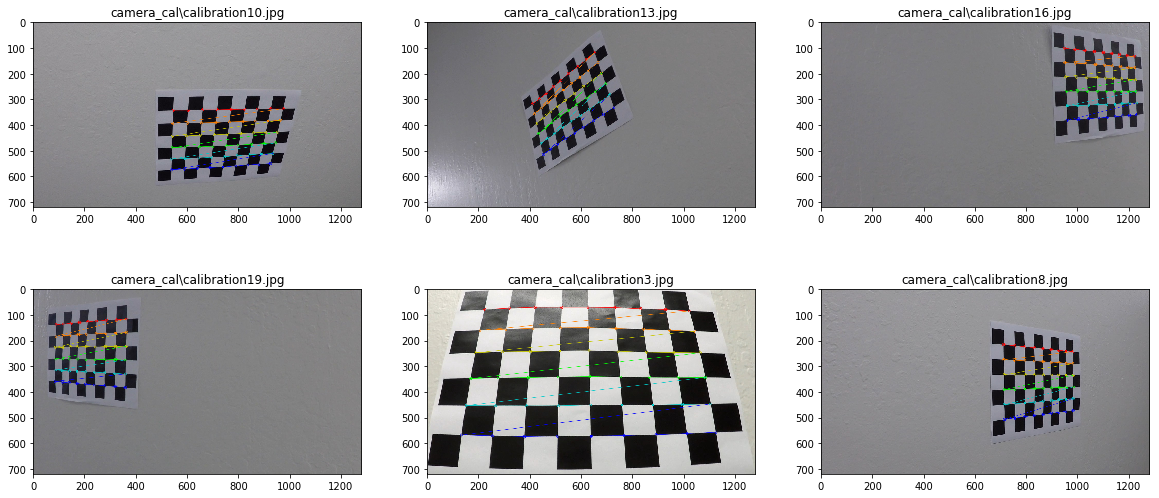

In [23]:

import cv2
import glob


n_corners = (9, 6)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((n_corners[0]*n_corners[1],3), np.float32)
objp[:,:2] = np.mgrid[0:n_corners[0], 0:n_corners[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
image_files = glob.glob('camera_cal/calibration*.jpg')

chessboardImages = []
chessboardNames = []
chessboardCornerNames = []
chessboardCornerImages = []
# Step through the list and search for chessboard corners
for idx, fname in enumerate(image_files):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    chessboardImages.append(img)
    chessboardNames.append(fname)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cornerImg = img.copy()
        cv2.drawChessboardCorners(cornerImg, n_corners, corners, ret)
        chessboardCornerImages.append(cornerImg)
        chessboardCornerNames.append(fname)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)

plot_image_array(chessboardCornerImages[::3], chessboardCornerNames[::3], ncols=3, nrows=2)

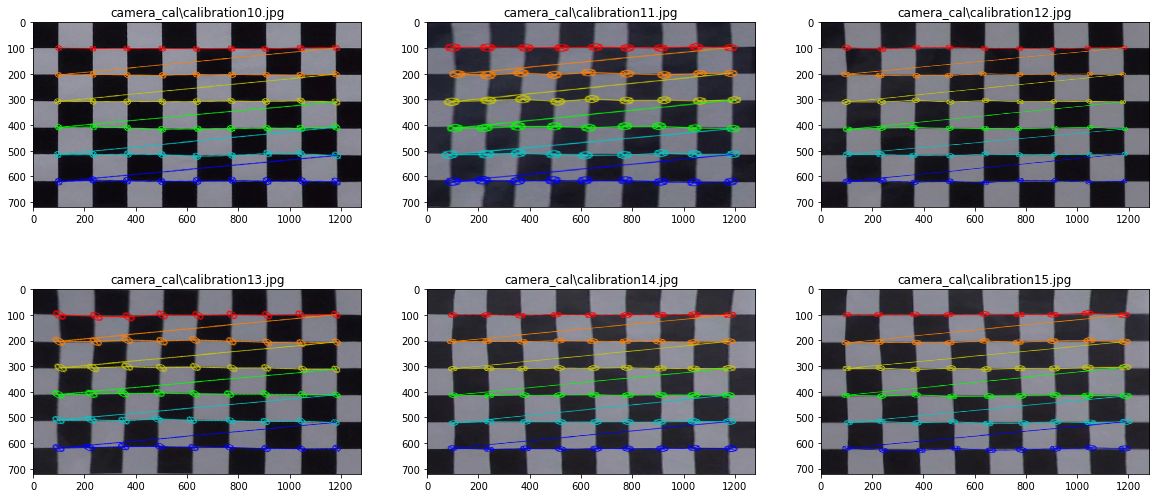

In [24]:
import pickle

img_size = (chessboardImages[0].shape[1], chessboardImages[0].shape[0])
# Do camera calibration given object points and image points
#print(objpoints)
#print(imgpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Make a list of calibration images
# Step through the list and search for chessboard corners
undistortedImages = []
undistortedNames = []
for idx, img in enumerate(chessboardImages):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    #undistortedImages.append(gray)
    #undistortedNames.append(chessboardNames[idx])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If corners found: 
    if ret:
        # a) draw corners
        cv2.drawChessboardCorners(undist, n_corners, corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (undist.shape[1], undist.shape[0])
        src = np.float32([corners[0], corners[n_corners[0]-1], corners[-1], corners[-n_corners[0]]])

        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])


        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        undistortedImages.append(warped)
        undistortedNames.append(chessboardNames[idx])
        
plot_image_array(undistortedImages, undistortedNames, ncols=3, nrows=2)
        
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
cam_calibration = {}
cam_calibration["mtx"] = mtx
cam_calibration["dist"] = dist
pickle.dump( cam_calibration, open( "camera_calibration.p", 'wb'))

In [25]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def combined_channel_threshold(img, channels=[0, 1, 2], thresh=[(0, 255), (0, 255), (0, 255)], color_conversion = cv2.COLOR_BGR2HLS):
    if color_conversion:
        c = cv2.cvtColor(img, color_conversion)
    else:
        c = img       
    b = []
    for channel, t in zip(channels, thresh):
        s = c[:,:,channel]
        binary_output = np.zeros(s.shape, dtype=np.uint8)
        binary_output[(s >= t[0]) & (s <= t[1])] = 1
        b.append(binary_output)
    
    return np.minimum.reduce(np.dstack(tuple(b)), axis=2)

#combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)

In [26]:
import os
import os.path

cam_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
print('Loaded camera calibration')
print('--------------------------')
print('mtx:\n', cam_calibration['mtx'])
print('\ndist:\n', cam_calibration['dist'])

def save_images(folder, images, names, binary=False):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for img, fname in zip(images, names):
        p = os.path.join(folder, fname)
        if p[-4:] != '.jpg':
            p += '.jpg'
        if binary:
            img = img * 255
        cv2.imwrite(p, img)
    
def undistort_image(img):
    return cv2.undistort(img, cam_calibration['mtx'], cam_calibration['dist'], None, cam_calibration['mtx'])

Loaded camera calibration
--------------------------
mtx:
 [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

dist:
 [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


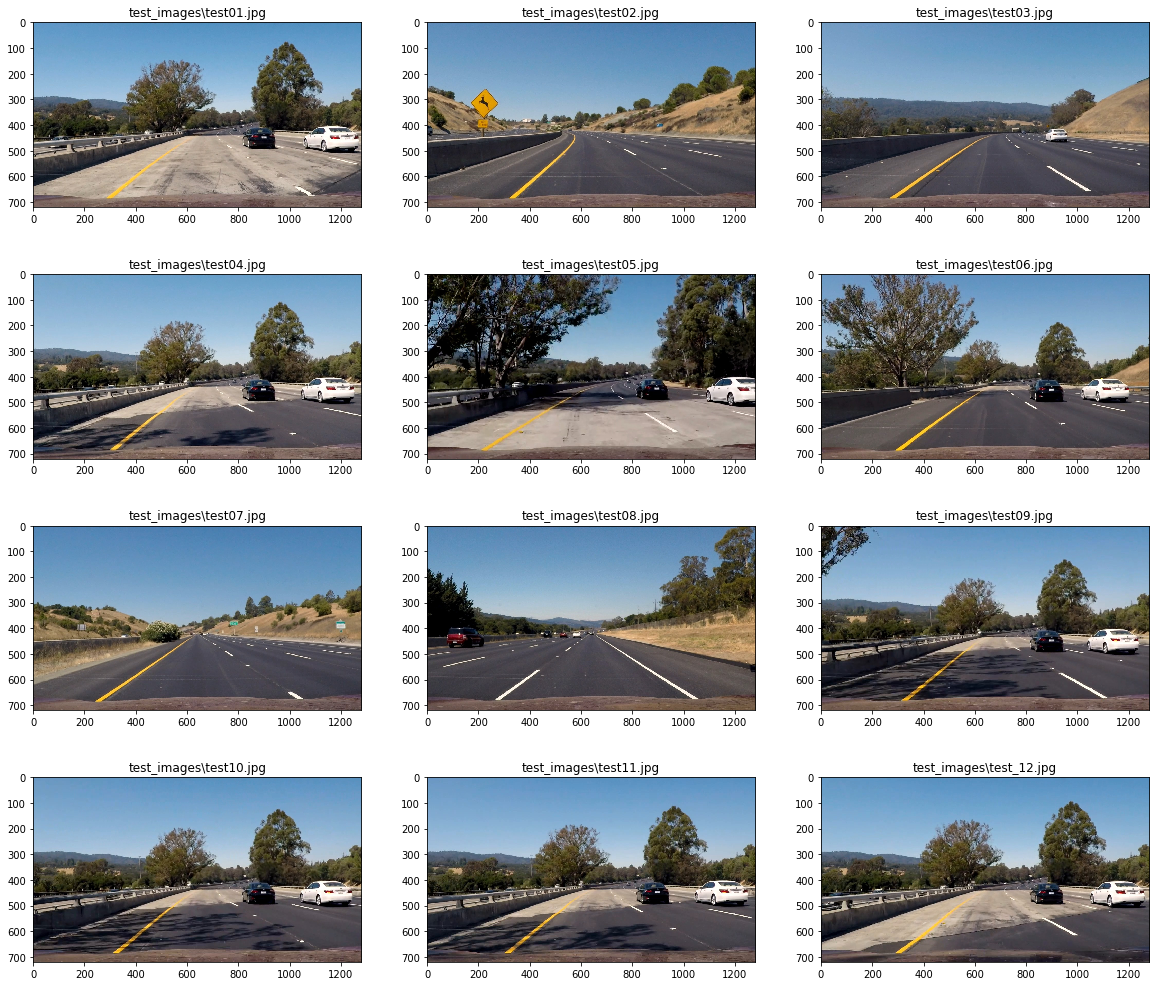

In [130]:

image_files = glob.glob('test_images/test*.jpg')

test = []
test_n = []
for idx, fname in enumerate(image_files):
    test.append(cv2.imread(fname))
    test_n.append(fname)
    
plot_image_array(test, test_n, ncols=3)   

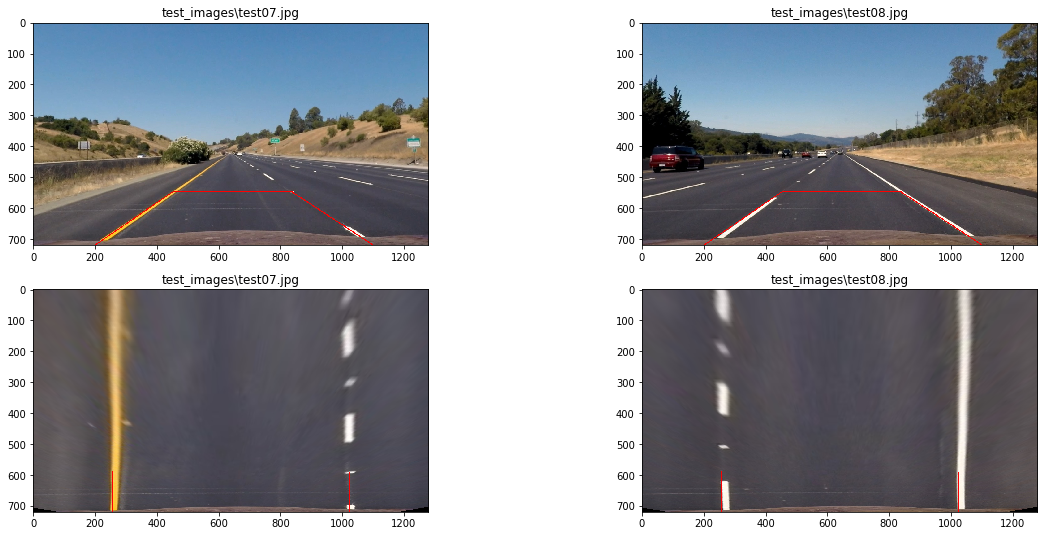

In [120]:
straight_image = test[6]
img_size = (straight_image.shape[1], straight_image.shape[0])

w,h = 1280,720
x,y = 0.6*w, 0.8*h
warp_src = np.float32([[200./1280*w,720./720*h],
              [453./1280*w,547./720*h],
              [835./1280*w,547./720*h],
              [1100./1280*w,720./720*h]])
warp_dst = np.float32([[(w-x)/2.,h],
              [(w-x)/2.,0.82*h],
              [(w+x)/2.,0.82*h],
              [(w+x)/2.,h]])

#warp_src = np.float32([[585, 460],
#                      [203, 720],
#                      [1127, 720],
#                      [695, 460]])

#warp_dst = np.float32([[320, 0],
#                      [320, 720],
#                      [960, 720],
#                      [960, 0]])


M_perspective = cv2.getPerspectiveTransform(warp_src.astype(np.float32), warp_dst.astype(np.float32))
Minv_perspective = cv2.getPerspectiveTransform(warp_dst.astype(np.float32), warp_src.astype(np.float32))

def draw_lines(src, lines, color = [0, 0, 255], thickness = 2, skip = False):
    img = src
    if len(img.shape) == 2:
        if np.max(src) <= 1:
            img = np.uint8(img.reshape((img.shape[0], img.shape[1], 1)) * 255)
            img = np.repeat(img, 3, axis=2)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    s = 2 if skip else 1
    for p in range(0, len(lines) - 1, s):
        cv2.line(img, tuple(lines[p].astype(int)), tuple(lines[p+1].astype(int)), color, thickness)
    return img
        

def warp_to_image_plane(img, M = M_perspective):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
out = []
out_n = []
for i in range(6, 8):
    c = draw_lines(undistort_image(test[i]), warp_src)
    out.append(c)
    out_n.append(test_n[i])
    
for i in range(6, 8):
    warped = warp_to_image_plane(undistort_image(test[i]), M_perspective)
    cv2.imwrite("output_images/warped_{}.jpg".format(i), warped);
    warped = draw_lines(warped, warp_dst, skip = True)
    out.append(warped)
    out_n.append(test_n[i])
    
plot_image_array(out, out_n, ncols=2)

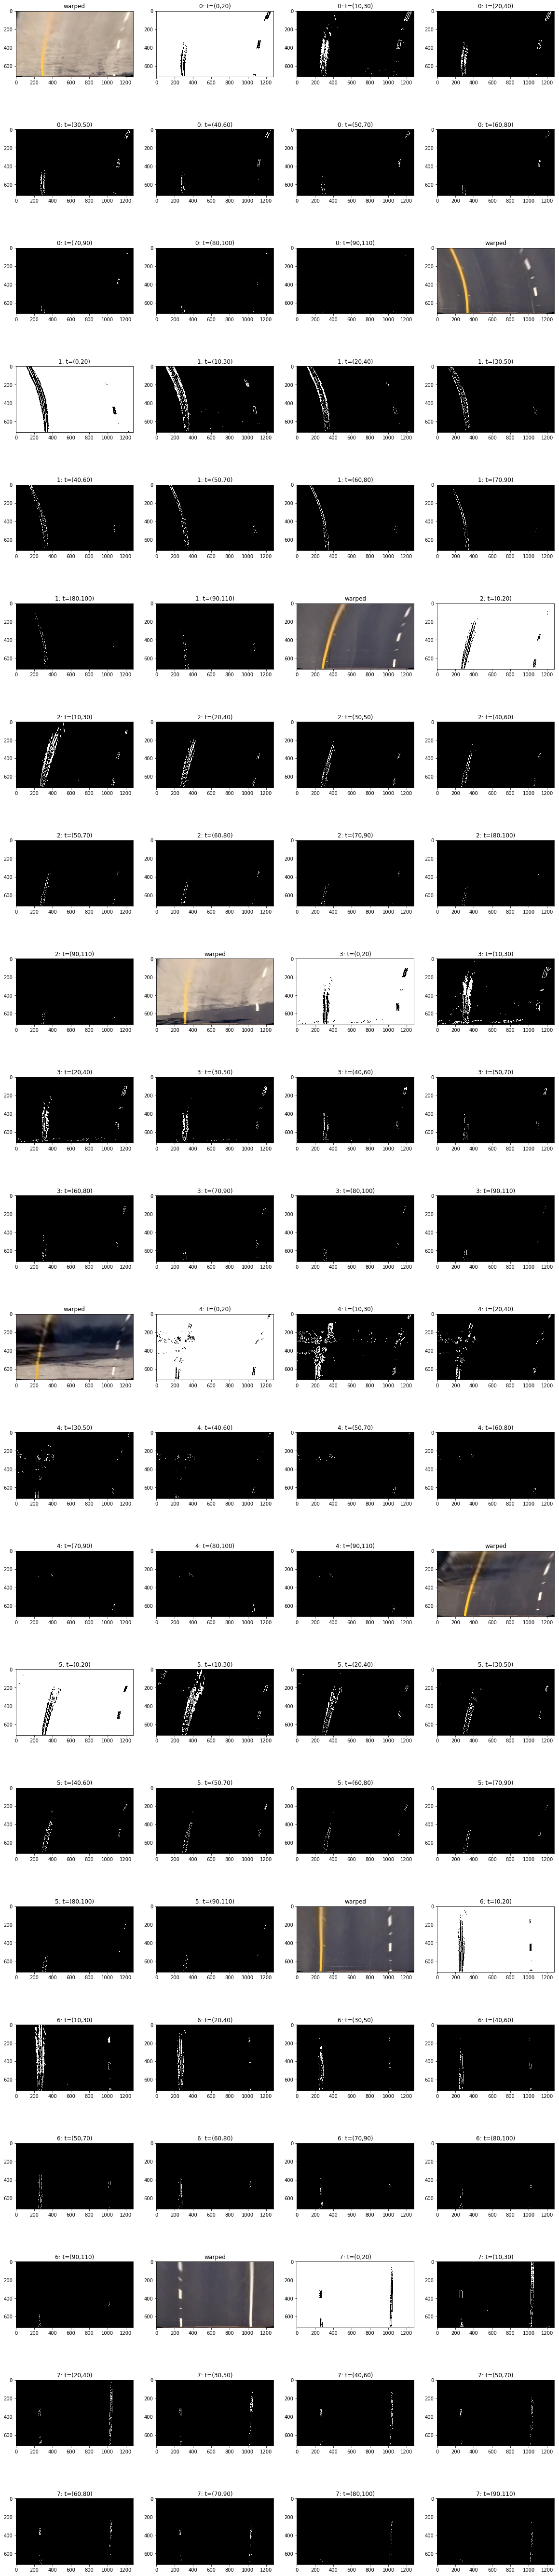

In [121]:
test_img = test[1]

# abs sobel x (5, 25, 100)
# mag thresh (9, 30, 100)
# dir sobel (15, 0.8, 1.2)
# s-channel (100, 255)
# l-channel (0, 100)


out = []
out_n = []
tmin = 0
tmax = 255
window = 20
step = 10
k = 5
i = 7
for i in range(0,8):
    #undistort image
    undistort = undistort_image(test[i])
    #out.append(undistort)
    #out_n.append(img_prefix + 'undistorted')

    # warp image
    warped = warp_to_image_plane(undistort)
    out.append(warped)
    out_n.append('warped')
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    for t in range(0, 100, step):
        t1 = t + window
        binary_gx = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=7, thresh=(t, t1))
        out.append(binary_gx)
        out_n.append("{}: t=({},{})".format(i, t, t1))


#save_images('test_images/hls/l_t', out, out_n, binary=True)
plot_image_array(out, out_n, ncols=4)   

#imgplot = plt.imshow(out[0], cmap = 'gray')

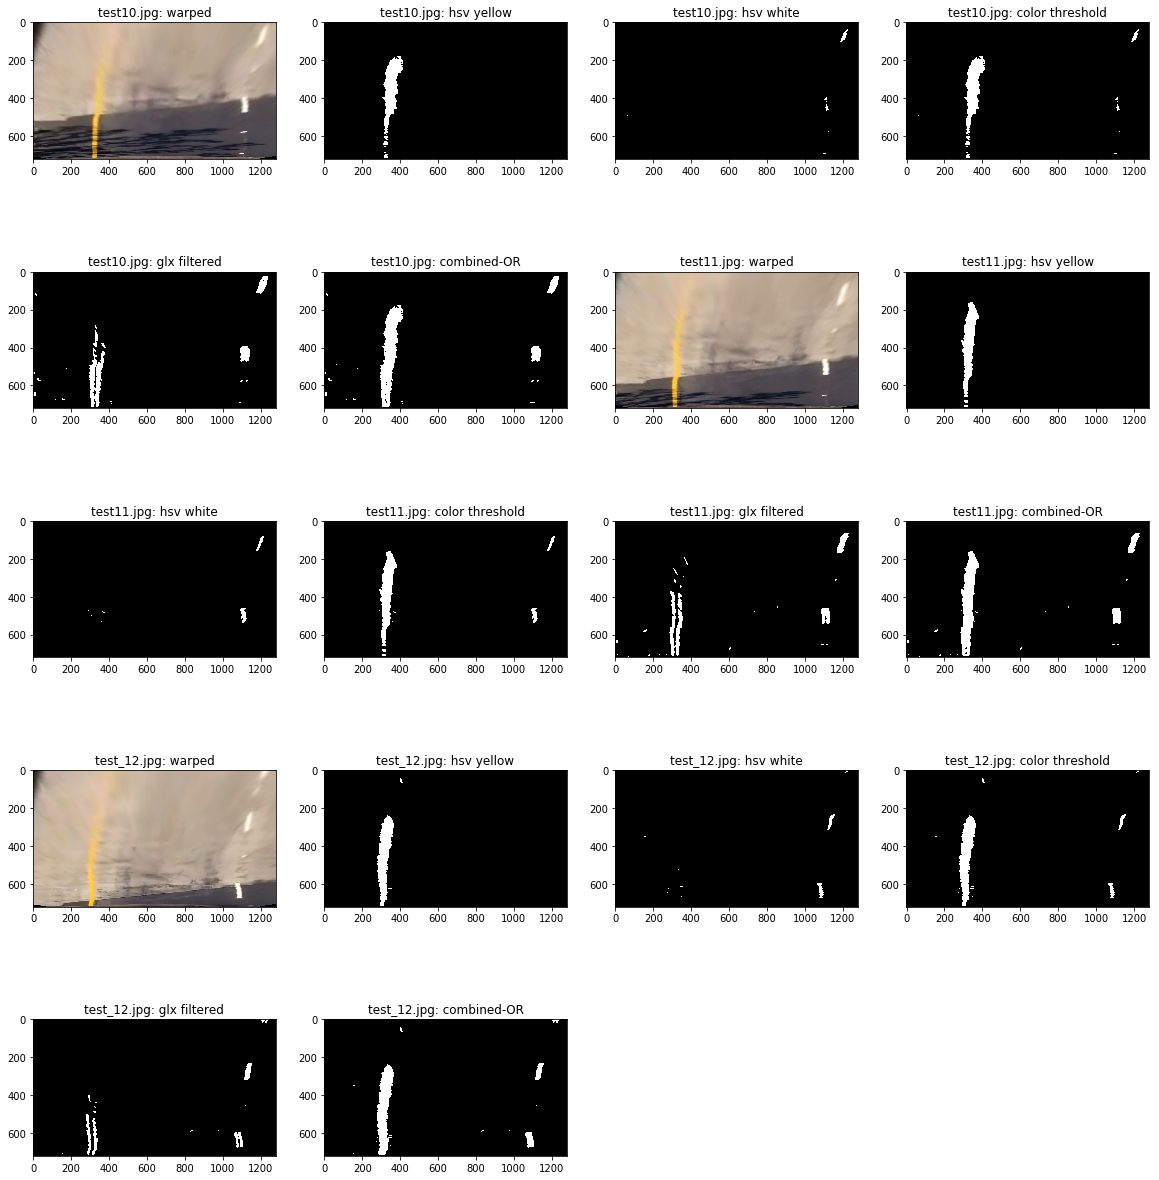

In [131]:


def preprocess_image(img, img_name = ''):
    out = []
    out_n = []
    
    img_prefix = img_name + ': '
    
    #undistort image
    undistort = undistort_image(img)

    # warp image
    warped = warp_to_image_plane(undistort)
    out.append(warped)
    out_n.append(img_prefix + 'warped')
    
    # apply color thresholds
    binary_hsv_yellow = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(0, 40), (80, 255), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)   
    binary_hsv_white = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(20, 255), (0, 80), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)
    out.append(binary_hsv_yellow)
    out_n.append(img_prefix + 'hsv yellow')
    out.append(binary_hsv_white)
    out_n.append(img_prefix + 'hsv white')
    
    # combine color thresholds for later demonstration
    binary_color = np.zeros_like(binary_hsv_white, dtype=np.uint8)
    binary_color[(binary_hsv_yellow == 1) | (binary_hsv_white == 1)] = 1
    out.append(binary_color)
    out_n.append(img_prefix + 'color threshold')
    
    # detect vertical lines with sobel in x-direction
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    binary_gx_l = abs_sobel_thresh(hls[:,:,1], orient='x', sobel_kernel=7, thresh=(40, 255))
    binary_gx_s = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=7, thresh=(25, 255))
    
    # combine gradients for later demonstration
    binary_sobel = np.zeros_like(binary_gx_l, dtype=np.uint8)
    binary_sobel[(binary_gx_l == 1) | (binary_gx_s == 1)] = 1
    binary_gx_filtered = cv2.medianBlur(binary_sobel, 9) 
    out.append(binary_gx_filtered)
    out_n.append(img_prefix + 'glx filtered')  
    
    # combine all threshold images
    binary = np.zeros_like(binary_color)
    binary[(binary_color == 1) | (binary_gx_filtered == 1)] = 1
    out.append(binary)
    out_n.append(img_prefix + 'combined-OR')
    
    return undistort, binary, out, out_n

out = []
out_n = []
i=4
for i in range(9, len(test)):
    _, warped, o, o_n = preprocess_image(test[i], img_name = os.path.split(test_n[i])[-1])
    out += o
    out_n += o_n

plot_image_array(out, out_n, ncols=4) 

In [209]:
import operator
import scipy.misc

class SlidingWindow:

    def __init__(self, start_pos_x, image_height, n_windows = 9, window_margin = 100):
        self.window_height = np.int(image_height / n_windows)
        self.margin = window_margin
        self.image_height = image_height
        pos = []
        for p in start_pos_x:
            pos.append([(-1, p)])
        self.pos_x = tuple(pos)
        
    def set_window_x(self, level, window_index, window_pos_x):
        self.pos_x[window_index].append((level, window_pos_x))
    
    def get_window_y(self, level):
        y_high = self.image_height - level * self.window_height
        y_low = y_high - self.window_height
        return y_low, y_high
    
    def get_window_x(self, level, window_index):
        cur_lvl, cur_x = self.pos_x[window_index][-1]
        if cur_lvl > 0:
            diff = tuple(map(operator.sub, (cur_lvl, cur_x), self.pos_x[window_index][-2]))
            offset = (level - cur_lvl) * diff[1] / diff[0]
            cur_x += np.int(0.5 * offset)
        return cur_x - self.margin, cur_x + self.margin
            
        
class Lane:
    def __init__(self, size=10):
        self.poly = []
        self.id = []
        self.pixel = []
        self.size = size
        self.curverad = []
        
    def get_poly(self, mode='current'):
        if len(self.poly) > 0:      
            if mode == 'current':
                return self.poly[0], self.id[0]
            elif mode == 'mean':
                return np.mean(np.array(self.poly), axis=0), self.id[0]
        return np.array([]), -1
    
    def get_pixel_count(self, mode='current'):
        if len(self.pixel) > 0:      
            if mode == 'current':
                return self.pixel[0]
            elif mode == 'mean':
                return np.mean(np.array(self.poly))
        return 0
    
    def get_curve_radius(self, mode='current'):
        if len(self.curverad) > 0:      
            if mode == 'current':
                return self.curverad[0]
            elif mode == 'mean':
                return np.mean(np.array(self.curverad), axis=0)
        return 0
    
    def add_poly(self, p, p_id, curverad):
        self.poly = [p[0]] + self.poly[:self.size - 1]
        self.pixel = [p[1]] + self.pixel[:self.size - 1]
        self.id = [p_id] + self.id[:self.size - 1]
        self.curverad = [curverad] + self.curverad[:self.size - 1]
        
    def empty(self):
        return len(self.poly) == 0
        
class LanePair:
    def __init__(self, img_shape,  hist_size = 10, y_scale = 30/720, x_scale = 3.7/760):
        self.frame_counter = 0
        self.hist_size = hist_size
        self.img_shape = img_shape
        self.y_scale = y_scale
        self.x_scale = x_scale
        self.lanes = (Lane(size = hist_size), Lane(size = hist_size))
    
    def get_curve_radius(self, lane_index= -1, mode='mean'):
        if lane_index < 0:
            left = self.lanes[0].get_curve_radius(mode)
            right = self.lanes[1].get_curve_radius(mode)
            return (left + right) * 0.5
        else:
            return self.lanes[lane_index].get_curve_radius(mode)
    
    def get_center_offset(self, mode='mean'):
        left_fit = self.lanes[0].get_poly(mode)[0]
        right_fit = self.lanes[1].get_poly(mode)[0]
        
        if len(left_fit) < 1 or len(right_fit) < 1:
            return 0
        
        y_eval = self.img_shape[0]
        leftx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        rightx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        
        img_center = self.img_shape[1] * 0.5
        cur_center = (leftx + rightx) * 0.5
        return (cur_center - img_center) * self.x_scale
    
    def get_pixel_count(self, lane_index = -1, mode='mean'):
        if lane_index < 0:
            left = self.lanes[0].get_pixel_count(mode)
            right = self.lanes[1].get_pixel_count(mode)
            return (left + right) * 0.5
        else:
            return self.lanes[lane_index].get_pixel_count(mode)
        
    def get_poly(self, lane_index, mode='current'):
        return self.lanes[lane_index].get_poly(mode)
    
    def set_poly(self, left, right):
        curverad = [self.calculate_curveradius(left[2]),
                    self.calculate_curveradius(right[2])]
        
        self.delta_cr = [0, 0]
        self.delta_poly = [np.zeros(3), np.zeros(3)]
        p = [left, right]
        
        for i in range(2):
            if not self.lanes[i].empty():
                self.delta_cr[i] = curverad[i] - self.get_curve_radius(i, mode='mean')
                poly = self.get_poly(i, mode='mean')[0]
                self.delta_poly[i] = ((p[i][0] - poly) / poly  * 100)
                
        y_eval = self.img_shape[0]
        leftx = left[0][0]*y_eval**2 + left[0][1]*y_eval + left[0][2]
        rightx = right[0][0]*y_eval**2 + right[0][1]*y_eval + right[0][2]
        self.lane_dist = (rightx - leftx) * self.x_scale
        
        self.lanes[0].add_poly(left, self.frame_counter, curverad[0])
        self.lanes[1].add_poly(right, self.frame_counter, curverad[1])
        self.frame_counter += 1
        return True
    
    def calculate_curveradius(self, x_vals):
        ploty = np.linspace(0, self.img_shape[0]-1, self.img_shape[0])
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*self.y_scale, x_vals*self.x_scale, 2)
        
        # Calculate the new radii of curvature
        y_eval = np.max(ploty)
        curverad = ((1 + (2*fit_cr[0]*y_eval*self.y_scale + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curverad
    
def detect_lanes(binary_warped, lane_pair, debug = False):
    left_fit, left_id = lane_pair.get_poly(0)
    right_fit, right_id = lane_pair.get_poly(1)

    if debug:
        debug_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []    
    if left_id < 0 or right_id < 0:
        # we have no current lane fitting so we perform a sliding window search
        histogram = np.sum(warped[binary_warped.shape[0]//2:,:], axis=0)
                  
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint   
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        n_windows = 9
        window = SlidingWindow(start_pos_x=[leftx_base, rightx_base], 
                               image_height=binary_warped.shape[0], 
                               n_windows=n_windows, 
                               window_margin=margin)   

        # Step through the windows one by one
        for level in range(n_windows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low, win_y_high = window.get_window_y(level)
            win_xleft_low, win_xleft_high = window.get_window_x(level, 0)
            win_xright_low, win_xright_high = window.get_window_x(level, 1)

            # Draw the windows on the visualization image
            if debug:
                cv2.rectangle(debug_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
                cv2.rectangle(debug_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                window.set_window_x(level, 0, np.int(np.mean(nonzerox[good_left_inds])))
            if len(good_right_inds) > minpix:        
                window.set_window_x(level, 1, np.int(np.mean(nonzerox[good_right_inds])))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    else:
        # we have a current lane fitting we use its boundary to search for lanes
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
    # Fit a second order polynomial to each
    next_left_fit = np.polyfit(nonzeroy[left_lane_inds], nonzerox[left_lane_inds], 2)
    next_right_fit = np.polyfit(nonzeroy[right_lane_inds], nonzerox[right_lane_inds], 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    next_left_fitx = next_left_fit[0]*ploty**2 + next_left_fit[1]*ploty + next_left_fit[2]
    next_right_fitx = next_right_fit[0]*ploty**2 + next_right_fit[1]*ploty + next_right_fit[2]
    lane_pair.set_poly((next_left_fit, len(left_lane_inds.nonzero()[0]), next_left_fitx), (next_right_fit, len(right_lane_inds.nonzero()[0]), next_right_fitx))

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([next_left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([next_right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    if debug:
        # color pixels that contributed to lanes in debug image
        debug_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        debug_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # Draw the lane onto the warped blank image
        cv2.polylines(debug_img, np.int_([pts]), False, (0,255, 255), 3, cv2.LINE_AA)
 
        if left_id >= 0 and right_id >= 0:
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([next_left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([next_left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([next_right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([next_right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            window_img = np.zeros_like(debug_img)
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            debug_img = cv2.addWeighted(debug_img, 1, window_img, 0.3, 0)
            
            
    # for the actual lane detection we are using an average over the last reported lanes
    avg_left_fit = lane_pair.get_poly(lane_index=0, mode='mean')[0]
    avg_right_fit = lane_pair.get_poly(lane_index=1, mode='mean')[0]
        
    avg_left_fitx = avg_left_fit[0]*ploty**2 + avg_left_fit[1]*ploty + avg_left_fit[2]
    avg_right_fitx = avg_right_fit[0]*ploty**2 + avg_right_fit[1]*ploty + avg_right_fit[2]
     
    pts_left = np.array([np.transpose(np.vstack([avg_left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([avg_right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # draw lanes in blank image that will be warped  back later and overlayed onto the original image
    lane_img = np.zeros(binary_warped.shape + (3,), dtype=np.uint8)
    cv2.fillPoly(lane_img, np.int_([pts]), (0,255, 0))
    
    result =[lane_img]
    if debug:
        result += [debug_img]
    return result

def put_text(img, text, margin_x, y, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale = 1, color = (255, 255, 255), thickness = 1, line = cv2.LINE_AA, align='left'):
    if align == 'left':
        cv2.putText(img, text, (margin_x, y), fontFace, fontScale, color, thickness, cv2.LINE_AA)
    elif align == 'right':
        textsize,_ = cv2.getTextSize(text, fontFace, fontScale, thickness)
        cv2.putText(img, text, (img.shape[1] - margin_x - textsize[0], y), fontFace, fontScale, color, thickness, line)
    elif align == 'center':
        textsize,_ = cv2.getTextSize(text, fontFace, fontScale, thickness)
        cv2.putText(img, text, ((img.shape[1] - textsize[0]) // 2 + margin_x, y), fontFace, fontScale, color, thickness, line)
        
class LaneDetector:
    def __init__(self, img_type='bgr', img_shape=(720, 1280), debug = False):
        self.lane_pair = LanePair(img_shape=img_shape)
        self.debug = debug
        self.img_type = img_type
        
    def process_image(self, img):
        if self.img_type == 'rgb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
        undist, warped, prep_imgs, _ = preprocess_image(img)
        detection = detect_lanes(warped, self.lane_pair, debug=self.debug)        
        warped_detection = cv2.warpPerspective(detection[0], Minv_perspective, (undist.shape[1], undist.shape[0]))       
       
        # Combine the result with the original image
        lane_img = cv2.addWeighted(undist, 1, warped_detection, 0.3, 0)
        curverad = self.lane_pair.get_curve_radius(mode='mean')
        offset = self.lane_pair.get_center_offset(mode='mean')
        cv2.putText(lane_img,"radius of curvature: {:.0f}m".format(curverad),(20, 50), cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA)
        cv2.putText(lane_img,"vehicle offset from center: {:+.2f}m".format(offset),(20, 100), cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA)
        cv2.putText(lane_img, "{:04d}".format(self.lane_pair.frame_counter), (1180, 40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),1, cv2.LINE_AA)
        
        if self.debug:
            h, w, d = lane_img.shape
            embedded = np.zeros((h, np.int32(w * 1.5), d), dtype=np.uint8)
            embedded[0:h, 0:w, ] = lane_img
            debug_img = cv2.addWeighted(prep_imgs[0], 0.3, detection[1], 1, 0)
            debug_img = scipy.misc.imresize(debug_img, size=(h//2, w//2, 3))
            embedded[0:debug_img.shape[0], w:w+debug_img.shape[1], ] = debug_img
            
            text_img = np.zeros_like(debug_img)
            left_curve = self.lane_pair.get_curve_radius(lane_index=0, mode='current')
            right_curve = self.lane_pair.get_curve_radius(lane_index=1, mode='current')
            center = self.lane_pair.get_center_offset(mode='current')
            left_pix = self.lane_pair.get_pixel_count(lane_index=0, mode='current')
            right_pix = self.lane_pair.get_pixel_count(lane_index=1, mode='current')
            dcr = self.lane_pair.delta_cr
            dp = self.lane_pair.delta_poly
            dl = self.lane_pair.lane_dist
            
            put_text(text_img, "{:.0f} m".format(left_curve),10, 50, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:.0f} m".format(right_curve),10, 50, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:+.2f} m".format(center),0, 50, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'center')
            put_text(text_img, "{:+.0f} m".format(dcr[0]),10, 100, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.0f} m".format(dcr[1]),10, 100, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:d} px".format(left_pix),10, 150, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:d} px".format(right_pix),10, 150, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:.2f} m".format(dl),0, 220, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'center')
            put_text(text_img, "{:+.2f}%".format(dp[0][0]),10, 220, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.2f}%".format(dp[0][1]),10, 270, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.2f}%".format(dp[0][2]),10, 320, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'left')
            put_text(text_img, "{:+.2f}%".format(dp[1][0]),10, 220, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:+.2f}%".format(dp[1][1]),10, 270, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            put_text(text_img, "{:+.2f}%".format(dp[1][2]),10, 320, cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2, cv2.LINE_AA, 'right')
            
            embedded[h//2:h//2+text_img.shape[0], w:w+text_img.shape[1], ] = text_img
            lane_img = embedded

        if self.img_type == 'rgb':
            lane_img = cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB)
        return lane_img
    
#out = []
#out_n = []
#for i in range(len(test)):
#    img_name = os.path.split(test_n[i])[-1]
#    _, warped, _, _ = preprocess_image(test[i], img_name = img_name)
#    _, img, _, _  = detect_lanes(warped)
#    out.append(img)
#    out_n.append(img_name)
    
#plot_image_array(out, out_n, ncols=2) 

## Helper Functions
The following helper functions are taken from the template notebook and might have been modified to fit my needs (e.g. draw_lines)

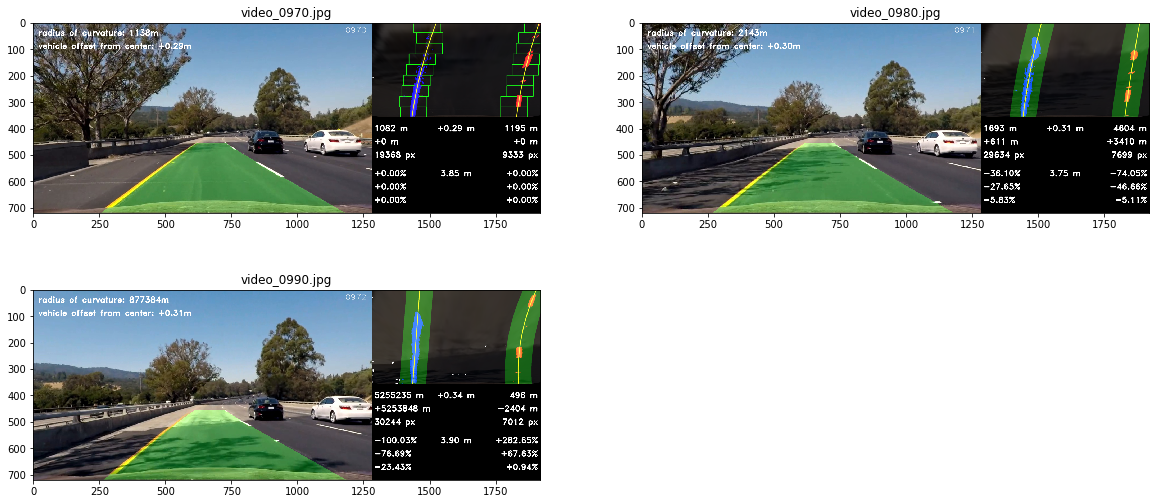

In [210]:
image_files = glob.glob('debug_images/video_*.jpg')

video = []
video_n = []
for idx, fname in enumerate(image_files):
    video.append(cv2.imread(fname))
    video_n.append(fname)

out = []
out_n = []
lane_detector = LaneDetector(debug=True)
lane_detector.lane_pair.frame_counter = 969
for i in range(0, len(video), 10):
    img_name = os.path.split(video_n[i])[-1]
    out.append(lane_detector.process_image(video[i]))
    out_n.append(img_name)
    
#save_images('output_images', out, out_n)    
plot_image_array(out, out_n, ncols=2) 

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`



In [112]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [132]:
class VideoScraper:
    def __init__(self, first_frame = 0, last_frame = -1, folder = 'debug_images'):
        self.folder = folder
        self.img_counter = 0
        self.first_frame = first_frame
        self.last_frame = last_frame

    def process_image(self, img):
        if self.img_counter >= self.first_frame and (self.img_counter <= self.last_frame or self.last_frame == -1):
            cv2.imwrite(os.path.join(self.folder, "video_{:04d}.jpg".format(self.img_counter)), cv2.cvtColor(img, cv2.COLOR_RGB2BGR));
        self.img_counter += 1

        return img


Let's try the one with the solid white lane on the right first ...

In [211]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
#video_filter = VideoScraper(first_frame = 970, last_frame = 999)
video_filter = LaneDetector(img_type='rgb', debug=True)
white_clip = clip1.fl_image(video_filter.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:56<00:00,  2.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 7min 59s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:22<00:00, 30.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 23.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))